In [2]:
# !pip install torch
# !pip install torchvision

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [4]:
# VAE Architecture
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(4*4*128, latent_dim)
        self.fc_logvar = nn.Linear(4*4*128, latent_dim)
        # Decoder
        self.fc_z = nn.Linear(latent_dim, 4*4*128)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_z(z).view(-1, 128, 4, 4)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [8]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [6]:
# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [9]:
# Load MNIST dataset and run the training
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

vae = VAE(128).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)


Files already downloaded and verified
Epoch 1, Loss: 1941.564343125
Epoch 2, Loss: 1852.4174346875
Epoch 3, Loss: 1837.934608125
Epoch 4, Loss: 1832.05408125
Epoch 5, Loss: 1828.8279484375
Epoch 6, Loss: 1826.5610321875
Epoch 7, Loss: 1824.9117853125
Epoch 8, Loss: 1823.9560896875
Epoch 9, Loss: 1822.8687715625
Epoch 10, Loss: 1822.0742965625


In [14]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=128):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].permute(1, 2, 0))
        axs[i].axis('off')
    plt.show()




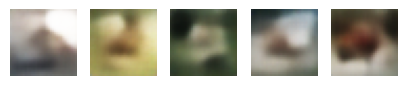

In [15]:
# Assuming you have already trained the model (vae) and it has a latent dimension of 20
generate_images(vae, num_images=5, latent_dim=128)

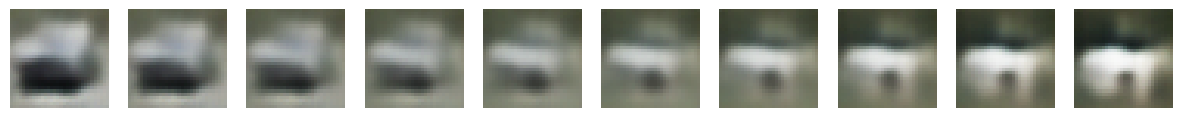

In [18]:
import numpy as np

def interpolate_latents(model, img1, img2, steps=10):
    model.eval()
    with torch.no_grad():
        mu1, logvar1 = model.encode(img1.unsqueeze(0))
        z1 = model.reparameterize(mu1, logvar1)

        mu2, logvar2 = model.encode(img2.unsqueeze(0))
        z2 = model.reparameterize(mu2, logvar2)

        interpolated_images = []
        for alpha in np.linspace(0, 1, steps):
            z_interp = z1 * (1 - alpha) + z2 * alpha
            recon_img = model.decode(z_interp).squeeze(0).cpu().numpy().transpose(1, 2, 0)
            interpolated_images.append(recon_img)

    return interpolated_images

dataset = next(iter(train_loader))[0]
img1, img2 = dataset[0], dataset[1]

interpolated_images = interpolate_latents(vae, img1, img2)

fig, axes = plt.subplots(1, len(interpolated_images), figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(interpolated_images[i])
    ax.axis("off")
plt.show()

Files already downloaded and verified
Epoch 1, Loss: 1927.4170628125
Epoch 2, Loss: 1845.40397375
Epoch 3, Loss: 1833.8032696875
Epoch 4, Loss: 1829.1750478125
Epoch 5, Loss: 1826.1686728125


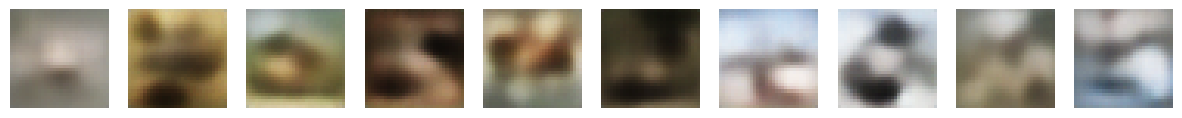

In [19]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

new_train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)

latent_dim = 64
new_model = VAE(latent_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = optim.Adam(new_model.parameters(), lr=1e-3)
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    train(new_model, new_train_loader, optimizer, epoch)

def generate_samples(model, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        generated_images = model.decode(z).cpu().numpy().transpose(0, 2, 3, 1)
    return generated_images

generated_images = generate_samples(new_model, 10)

fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i])
    ax.axis("off")
plt.show()